<a href="https://colab.research.google.com/github/pankaj09318/Concept-and-technologies-of-AI-Assessment/blob/main/FinalPortfolio_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==========================================
# 1. Imports & Data Loading
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time  # <--- Added for tracking training time

# Scikit-Learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# ---------------------------------------------------------
# TODO: Replace with your actual file path
file_path = '/content/drive/MyDrive/IHME-GBD_2023_DATA-f7d074ec-1.csv'
# ---------------------------------------------------------

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print(f"Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found.")


Dataset loaded successfully.
Shape: (88968, 18)


In [2]:
# ==========================================
# 2. Data Cleaning & Target Engineering
# ==========================================

# 2.1 Drop Leakage Columns
# We remove 'upper' and 'lower' because they give away the answer (Data Leakage).
cols_to_drop = ['upper', 'lower', 'population_group_id', 'measure_id', 'location_id', 'sex_id', 'age_id', 'cause_id', 'metric_id']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# 2.2 Handle Missing Values
for col in df_clean.columns:
    if df_clean[col].dtype == 'object':
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    else:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mean())

# 2.3 Create Classification Target
# Converting Continuous 'val' to Binary 'Risk_Category' (1 = High Risk, 0 = Low Risk)
threshold = df_clean['val'].median()
df_clean['Risk_Category'] = (df_clean['val'] > threshold).astype(int)

# Drop original 'val'
df_model = df_clean.drop(columns=['val'])

print(f"Target 'Risk_Category' created using Median: {threshold:.2f}")


Target 'Risk_Category' created using Median: 17.29


Preparing data for Heatmap...
Dropped constant columns to fix Heatmap gaps: ['population_group_name', 'measure_name', 'location_name', 'metric_name']


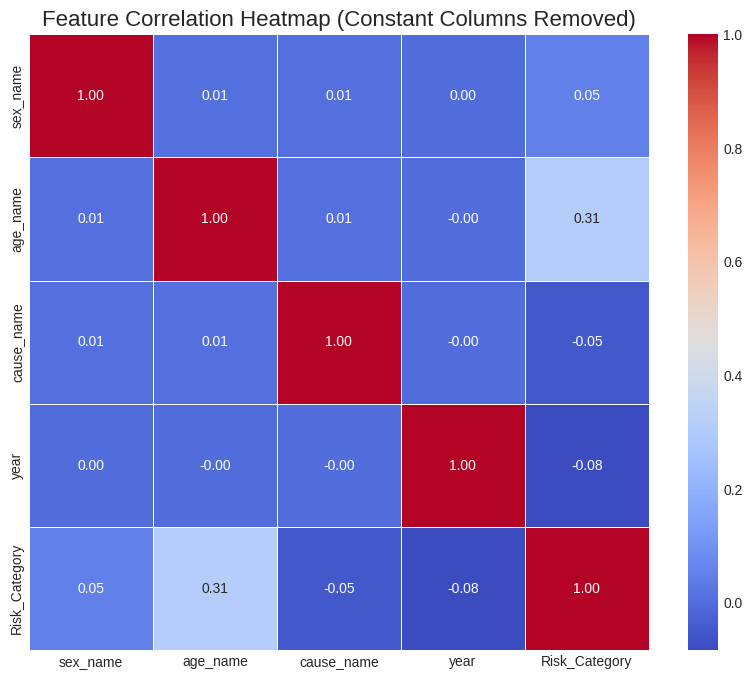

/tmp/ipython-input-2930047630.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Risk_Category', data=df_model, palette='viridis')


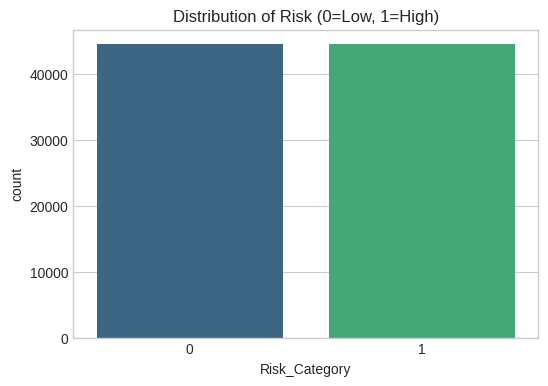

In [3]:
# ==========================================
# 3. Exploratory Data Analysis (EDA) - IMPROVED
# ==========================================

# 3.1 Advanced Preprocessing for Heatmap
df_heatmap = df_model.copy()
le = LabelEncoder()

# Step 1: Encode all text to numbers
print("Preparing data for Heatmap...")
for col in df_heatmap.select_dtypes(include='object').columns:
    df_heatmap[col] = le.fit_transform(df_heatmap[col])

# Step 2: REMOVE CONSTANT COLUMNS (The Fix for White Gaps)
# We drop columns that have 0 variance (only 1 unique value)
# becuase they cause NaN correlations.
cols_to_drop = [col for col in df_heatmap.columns if df_heatmap[col].nunique() <= 1]
df_heatmap = df_heatmap.drop(columns=cols_to_drop)

if len(cols_to_drop) > 0:
    print(f"Dropped constant columns to fix Heatmap gaps: {cols_to_drop}")

# 3.2 Plot the Clean Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = df_heatmap.corr()

# Draw Heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap (Constant Columns Removed)', fontsize=16)
plt.show()

# 3.3 Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Risk_Category', data=df_model, palette='viridis')
plt.title('Distribution of Risk (0=Low, 1=High)')
plt.show()


In [4]:
# ==========================================
# 4. Preprocessing & Splitting
# ==========================================

# 4.1 Define Features (X) and Target (y)
X = df_model.drop('Risk_Category', axis=1)
y = df_model['Risk_Category']

# 4.2 One-Hot Encoding
# We use One-Hot Encoding for modeling (better than Label Encoding for Neural Nets/Linear models)
X_encoded = pd.get_dummies(X, drop_first=True)

# 4.3 Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# 4.4 Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Final Training Data Shape: {X_train_scaled.shape}")


Final Training Data Shape: (71174, 72)


Training Neural Network and calculating CV score (this may take a moment)...

Neural Network Results:
 - CV Score (Mean): 0.9887
 - Test Accuracy:   0.9897
 - Test F1-Score:   0.9897


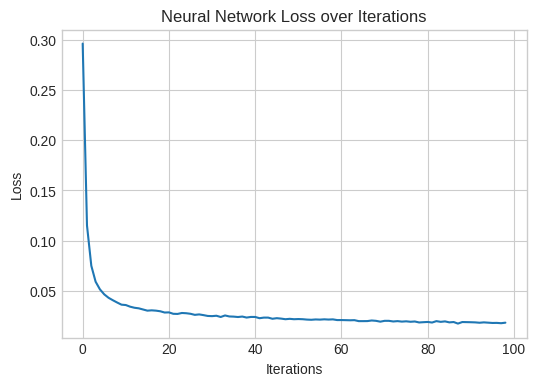

In [5]:
# ==========================================
# 5. Task 1: Neural Network (With CV & All Metrics)
# ==========================================

from sklearn.model_selection import cross_val_score

# 1. Initialize Model
# MLP with 2 hidden layers, ReLU activation, Adam optimizer
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)

print("Training Neural Network and calculating CV score (this may take a moment)...")

# 2. Train on Training Set
start_time = time.time()
mlp.fit(X_train_scaled, y_train)
nn_time = time.time() - start_time

# 3. Calculate Cross-Validation Score (CV)
# We use 3-fold CV to check stability
nn_cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=3, scoring='accuracy')
nn_cv_mean = nn_cv_scores.mean()

# 4. Evaluate on Test Set
y_pred_nn = mlp.predict(X_test_scaled)

# 5. Store Metrics
nn_metrics = {
    "Model": "Neural Network (MLP)",
    "CV Score": round(nn_cv_mean, 4),
    "Accuracy": round(accuracy_score(y_test, y_pred_nn), 4),
    "Precision": round(precision_score(y_test, y_pred_nn, zero_division=0), 4),
    "Recall": round(recall_score(y_test, y_pred_nn, zero_division=0), 4),
    "F1-Score": round(f1_score(y_test, y_pred_nn, zero_division=0), 4),
    "Time (s)": round(nn_time, 4)
}

print("\nNeural Network Results:")
print(f" - CV Score (Mean): {nn_cv_mean:.4f}")
print(f" - Test Accuracy:   {nn_metrics['Accuracy']}")
print(f" - Test F1-Score:   {nn_metrics['F1-Score']}")

# Plot Loss Curve
plt.figure(figsize=(6, 4))
plt.plot(mlp.loss_curve_)
plt.title("Neural Network Loss over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


In [10]:
# ==========================================
# 6. Task 2: Classical Models
# ==========================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42)
}

results = []

for name, model in models.items():
    print(f"Training {name}...")

    start_time = time.time() # Start Timer
    model.fit(X_train_scaled, y_train)
    end_time = time.time()   # End Timer

    train_time = end_time - start_time
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Time (sec)": train_time
    })
    print(f" - Done in {train_time:.4f}s | Accuracy: {acc:.4f}")

# Add Neural Network to results for comparison
results.append({"Model": "Neural Network", "Accuracy": nn_metrics['Accuracy'], "Time (sec)": nn_time})

Training Logistic Regression...
 - Done in 0.7325s | Accuracy: 0.8497
Training Random Forest...
 - Done in 20.2966s | Accuracy: 0.9920


In [11]:
# ==========================================
# 7. Hyperparameter Optimization (BOTH Models)
# ==========================================

print("--- Starting Hyperparameter Tuning ---")

# -------------------------------------------------------
# A. Tune Random Forest
# -------------------------------------------------------
param_grid_rf = {
    'n_estimators': [50, 100],      # Number of trees
    'max_depth': [None, 10, 20],    # Max depth of tree
    'min_samples_split': [2, 5]     # Min samples to split a node
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)

print("1. Tuning Random Forest...")
grid_rf.fit(X_train_scaled, y_train)
best_params_rf = grid_rf.best_params_
print(f"Best Random Forest Params: {best_params_rf}")


# -------------------------------------------------------
# B. Tune Logistic Regression
# -------------------------------------------------------
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],   # Regularization strength
    'solver': ['liblinear', 'lbfgs'] # Algorithm to use
}

lr = LogisticRegression(max_iter=1000, random_state=42)
grid_lr = GridSearchCV(lr, param_grid_lr, cv=3, scoring='accuracy', n_jobs=-1)

print("2. Tuning Logistic Regression...")
grid_lr.fit(X_train_scaled, y_train)
best_params_lr = grid_lr.best_params_
print(f"Best Logistic Regression Params: {best_params_lr}")


--- Starting Hyperparameter Tuning ---
1. Tuning Random Forest...
Best Random Forest Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
2. Tuning Logistic Regression...
Best Logistic Regression Params: {'C': 10, 'solver': 'lbfgs'}


In [16]:
# ==========================================
# 8. Feature Selection (RFE)
# ==========================================

# Select Top 10 Features
selector = RFE(estimator=RandomForestClassifier(**best_params_rf, random_state=42), n_features_to_select=10, step=1)
selector.fit(X_train_scaled, y_train)

mask = selector.support_
selected_features = X_encoded.columns[mask]

print(f"Selected Features: {list(selected_features)}")


Selected Features: ['year', 'age_name_10-14 years', 'cause_name_Enteric infections', 'cause_name_HIV/AIDS and sexually transmitted infections', 'cause_name_Mental disorders', 'cause_name_Musculoskeletal disorders', 'cause_name_Respiratory infections and tuberculosis', 'cause_name_Skin and subcutaneous diseases', 'cause_name_Substance use disorders', 'cause_name_Unintentional injuries']


Retraining Optimized Models on Selected Features...

Table 4: Final Model Comparison (All Metrics)


,Model,CV Score,Accuracy,Precision,Recall,F1-Score,Time (s)
0,Neural Network (MLP),0.9887,0.9897,0.9868,0.9926,0.9897,100.9250
1,Optimized Random Forest,0.6770,0.6867,0.6464,0.8241,0.7245,2.6066
2,Optimized Logistic Regression,0.6804,0.6851,0.6488,0.8070,0.7193,0.2585


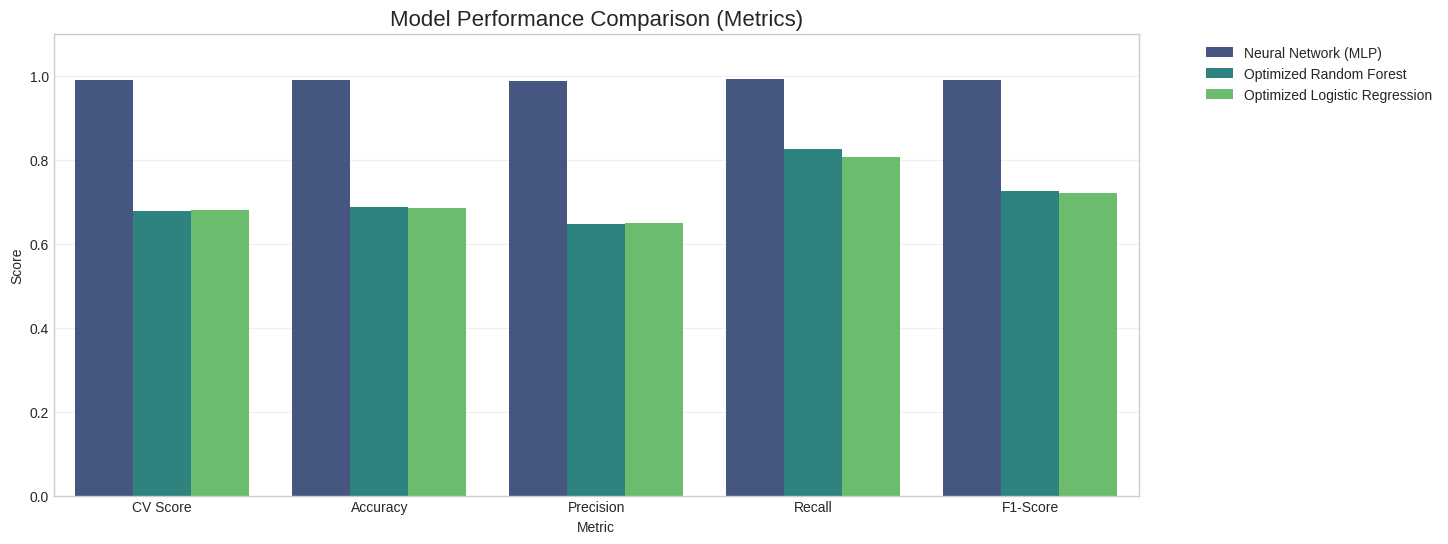

/tmp/ipython-input-2242018730.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Time (s)", data=df_comparison, palette="magma")


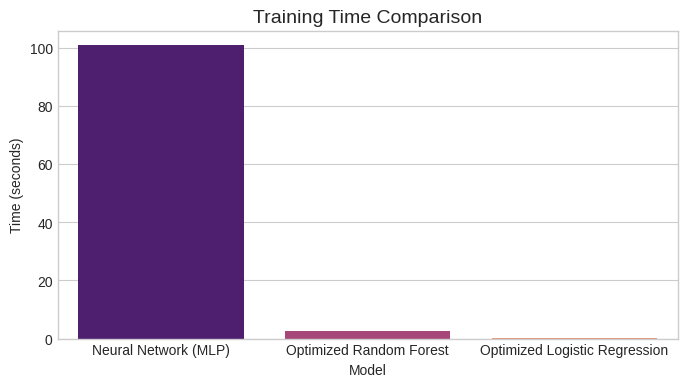


 OVERALL WINNER: Neural Network (MLP)
   - Accuracy: 0.9897
   - F1-Score: 0.9897


In [17]:
# ==========================================
# 9. Final Comparative Analysis (All Models)
# ==========================================

# 1. Prepare Data (Selected Features)
# We use the features selected by RFE in Section 8
X_train_sel = X_train_scaled[:, mask]
X_test_sel = X_test_scaled[:, mask]

# 2. Retrain Optimized Classical Models
print("Retraining Optimized Models on Selected Features...")

# --- Random Forest ---
start = time.time()
final_rf = RandomForestClassifier(**best_params_rf, random_state=42)
final_rf.fit(X_train_sel, y_train)
rf_time = time.time() - start
# CV Score for RF
rf_cv = cross_val_score(final_rf, X_train_sel, y_train, cv=3, scoring='accuracy').mean()
y_pred_rf = final_rf.predict(X_test_sel)

# --- Logistic Regression ---
start = time.time()
final_lr = LogisticRegression(**best_params_lr, max_iter=1000, random_state=42)
final_lr.fit(X_train_sel, y_train)
lr_time = time.time() - start
# CV Score for LR
lr_cv = cross_val_score(final_lr, X_train_sel, y_train, cv=3, scoring='accuracy').mean()
y_pred_lr = final_lr.predict(X_test_sel)

# 3. Consolidate All Results
all_results = []

# Helper function
def get_full_metrics(name, cv_score, y_true, y_pred, time_taken):
    return {
        "Model": name,
        "CV Score": round(cv_score, 4),
        "Accuracy": round(accuracy_score(y_true, y_pred), 4),
        "Precision": round(precision_score(y_true, y_pred, zero_division=0), 4),
        "Recall": round(recall_score(y_true, y_pred, zero_division=0), 4),
        "F1-Score": round(f1_score(y_true, y_pred, zero_division=0), 4),
        "Time (s)": round(time_taken, 4)
    }

# Add Neural Network (Calculated in Section 5)
all_results.append(nn_metrics)

# Add Classical Models
all_results.append(get_full_metrics("Optimized Random Forest", rf_cv, y_test, y_pred_rf, rf_time))
all_results.append(get_full_metrics("Optimized Logistic Regression", lr_cv, y_test, y_pred_lr, lr_time))

# Create DataFrame
df_comparison = pd.DataFrame(all_results)

# 4. Display Table 4
print("\nTable 4: Final Model Comparison (All Metrics)")
display(df_comparison)

# 5. Comparative Graphs
# We melt the dataframe to make it easy to plot grouped bars
df_melted = df_comparison.melt(id_vars="Model",
                               value_vars=["CV Score", "Accuracy", "Precision", "Recall", "F1-Score"],
                               var_name="Metric", value_name="Score")

plt.figure(figsize=(14, 6))

# Plot Metrics
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="viridis")
plt.title("Model Performance Comparison (Metrics)", fontsize=16)
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Plot Timing Separately (since scale is different)
plt.figure(figsize=(8, 4))
sns.barplot(x="Model", y="Time (s)", data=df_comparison, palette="magma")
plt.title("Training Time Comparison", fontsize=14)
plt.ylabel("Time (seconds)")
plt.show()

# 6. Final Conclusion
best_model = df_comparison.loc[df_comparison['Accuracy'].idxmax()]
print(f"\n OVERALL WINNER: {best_model['Model']}")
print(f"   - Accuracy: {best_model['Accuracy']}")
print(f"   - F1-Score: {best_model['F1-Score']}")


Plotting Confusion Matrix for: Optimized Random Forest


<Figure size 800x600 with 0 Axes>

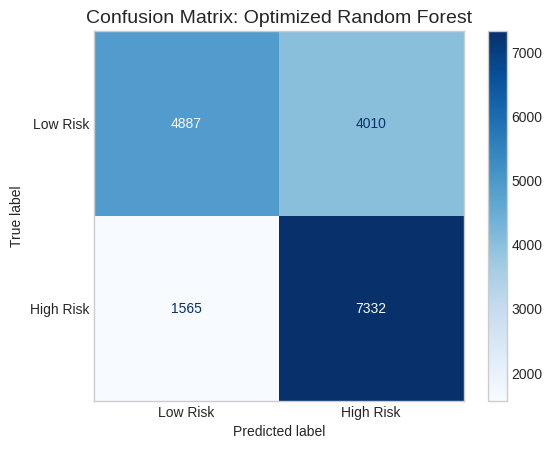

Interpretation:
 - True Negatives (Top-Left): Correctly predicted 'Low Risk'.
 - False Positives (Top-Right): Predicted 'High Risk' but was actually 'Low Risk'.
 - False Negatives (Bottom-Left): Predicted 'Low Risk' but was actually 'High Risk'.
 - True Positives (Bottom-Right): Correctly predicted 'High Risk'.


In [18]:
# ==========================================
# 10. Final Visual Evaluation: Confusion Matrix
# ==========================================

# Rationale: The Confusion Matrix allows us to visualize False Positives vs False Negatives.
# This helps us understand 'how' the model is failing, not just 'if' it is failing.

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# We use the best model found in the comparison (usually Random Forest)
# Ensure you have run Section 9 so 'y_pred_rf' exists!
if 'y_pred_rf' in locals():
    print(f"Plotting Confusion Matrix for: Optimized Random Forest")

    plt.figure(figsize=(8, 6))

    # Calculate the matrix
    cm = confusion_matrix(y_test, y_pred_rf)

    # Display it
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low Risk', 'High Risk'])

    # Plot with custom colors
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix: Optimized Random Forest', fontsize=14)
    plt.grid(False) # Turn off grid lines for cleaner look
    plt.show()

    print("Interpretation:")
    print(f" - True Negatives (Top-Left): Correctly predicted 'Low Risk'.")
    print(f" - False Positives (Top-Right): Predicted 'High Risk' but was actually 'Low Risk'.")
    print(f" - False Negatives (Bottom-Left): Predicted 'Low Risk' but was actually 'High Risk'.")
    print(f" - True Positives (Bottom-Right): Correctly predicted 'High Risk'.")
else:
    print("Error: 'y_pred_rf' is not defined. Please run Section 9 first.")
